<a href="https://colab.research.google.com/github/AbhilashIngale/EVA-Projects/blob/master/Session6/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import the dataset 
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
# Import the packages and dependencies 
import numpy as np
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.advanced_activations import ReLU, Softmax

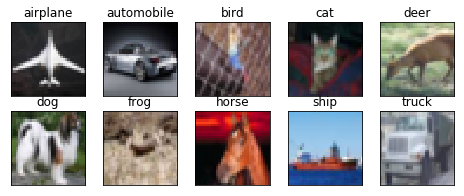

In [73]:
# Visualize classes 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
from keras.layers import SeparableConv2D
from keras.layers.merge import concatenate

input = Input(shape=(img_rows, img_cols, img_channels))

# Layer 1 - Normal Convolution                                                                      
Layer_1 = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input)        # Img size : 32x32 , R.F. : 3x3 
Layer_1 = BatchNormalization(name='norm_1')(Layer_1)
Layer_1 = ReLU()(Layer_1)

# Layer 2 - Spatially Separable Convolution 
Layer_2 = Conv2D(32, (1,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(Layer_1)
Layer_2 = BatchNormalization(name='norm_2')(Layer_2)
Layer_2 = ReLU()(Layer_2)
Layer_2 = Conv2D(64, (3,1), strides=(1,1), padding='same', name='conv_3', use_bias=False)(Layer_2)      # Img size : 32x32 , R.F. : 5x5 
Layer_2 = BatchNormalization(name='norm_3')(Layer_2)
Layer_2 = ReLU()(Layer_2)

# Layer 3 - Depthwise Separable Convolution 
Layer_3 = SeparableConv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same')(Layer_2)         # Img size : 32x32 , R.F. : 7x7   
Layer_3 = BatchNormalization(name='norm_4')(Layer_3)
Layer_3 = ReLU()(Layer_3)
Layer_3 = MaxPooling2D(pool_size=(2, 2))(Layer_3)                                                      # Img size : 16x16 , R.F. : 14x14

# Layer 4 - Group Convolutions (3x3 and 5x5)
Layer_4_01 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(Layer_3)  
Layer_4_02_01 = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(Layer_3)
Layer_4_02_02 = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_7', use_bias=False)(Layer_4_02_01)

Layer_4 = concatenate([Layer_4_01, Layer_4_02_02])                                                     # Img size : 16x16 , R.F. : 16x16 , 18x18 
Layer_4 = BatchNormalization(name='norm_5')(Layer_4)
Layer_4 = ReLU()(Layer_4)

# Layer 5 - Group Convolutions (with dilated kernels )
Layer_5_01 = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(Layer_4) 
Layer_5_02 = Conv2D(128, (3,3), strides=(1,1), padding='same', dilation_rate=(2, 2), name='conv_9', use_bias=False)(Layer_4)

Layer_5 = concatenate ([Layer_5_01,Layer_5_02])                                                        # Img size : 16x16 , R.F. : 18x18 , 20x20 
Layer_5 = BatchNormalization(name='norm_6')(Layer_5)
Layer_5 = ReLU()(Layer_5)

Layer_6 = Conv2D(10, (16,16), strides=(1,1), padding='same', name='conv_10', use_bias=False)(Layer_5)  

Layer_7= Flatten()(Layer_6)
output = Dense(num_classes, activation='softmax')(Layer_7)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [78]:
model = Model(inputs=[input], outputs=[output])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
re_lu_37 (ReLU)                 (None, 32, 32, 32)   0           norm_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Co

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 28s 71ms/step - loss: 3.7017 - acc: 0.2459 - val_loss: 2.2382 - val_acc: 0.2739
Epoch 2/50
390/390 [==============================] - 25s 65ms/step - loss: 2.4911 - acc: 0.3808 - val_loss: 2.8648 - val_acc: 0.3117
Epoch 3/50
390/390 [==============================] - 25s 65ms/step - loss: 2.3306 - acc: 0.4266 - val_loss: 2.6439 - val_acc: 0.3398
Epoch 4/50
390/390 [==============================] - 25s 65ms/step - loss: 1.9046 - acc: 0.4793 - val_loss: 2.4036 - val_acc: 0.4339
Epoch 5/50
390/390 [==============================] - 25s 65ms/step - loss: 1.7917 - acc: 0.5043 - val_loss: 2.9629 - val_acc: 0.3542
Epoch 6/50
390/390 [==============================] - 25s 65ms/step - loss: 1.9373 - acc: 0.5065 - val_loss: 2.0766 - val_acc: 0.3886
Epoch 7/50
390/390 [==============================] - 25s 65ms/step - loss: 1.6613 - acc: 0.5476 - val_loss: 2.0411 - val_acc: 0.3240
Epoch 8/50
390/390 [==============================] - 25s 65ms

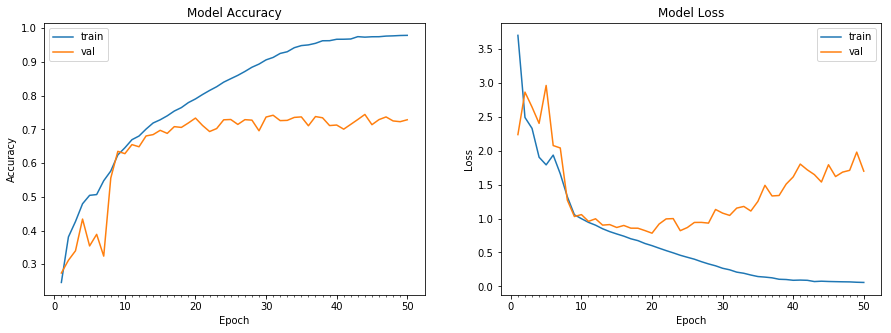

Accuracy on test data is: 72.85


In [80]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))